__What we are going to cover ?__
* Getting a custom dataset with pytorch
* Becoming one with the data (preparing and visualizing)
* Transforming data for use with a model
* Loading custom data with pre-built functions and custom functions
* Building FoodVision Mini to classify (pizza, sushi, steak) images
* Comparing models with and without Data Augmentation
* Making prediction on custom data

In [1]:
import torch
import numpy as np
import pandas as pd
from torch import nn
import matplotlib.pyplot as plt

In [2]:
# setting device agnostic code
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

# Getting a Custom Dataset With PyTorch
Our dataset is a subset of Food101 dataset. Our dataset starts with 3 classes of food and only 10% of the images.

In [3]:
# downloading the data

import requests
import zipfile
from pathlib import Path

# setup path to a data folder 
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# if the image folder does not exist, download and prepare it .. 
if image_path.is_dir():
    print(f"{image_path} directory already exists... skipping download")
else:
    print(f"{image_path} does not exist creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # download data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

data/pizza_steak_sushi directory already exists... skipping download


In [4]:
# setup train and test paths

train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

# Becoming one with the data (preparing and visualizing)

__Using PIL__

Image Class: pizza
Image Height And Width: 512, 512


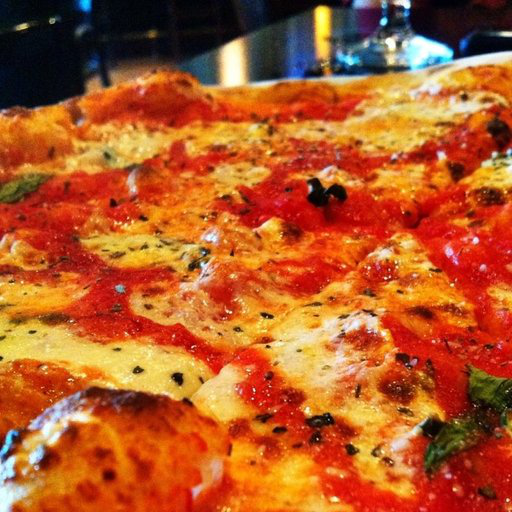

In [5]:
import random
from PIL import Image

random.seed(42) 

# getting paths of all images
image_path_list = list(image_path.glob("*/*/*.jpg"))

# select randomly from the image path list
random_image_path = random.choice(image_path_list)
random_image_class = random_image_path.parent.stem

# open image
img = Image.open(random_image_path)

# print metadata
print(f"Image Class: {random_image_class}")
print(f"Image Height And Width: {img.height}, {img.width}")
img

__Using Matplotlib__

Image Class: steak
Image Shape: (384, 512, 3)


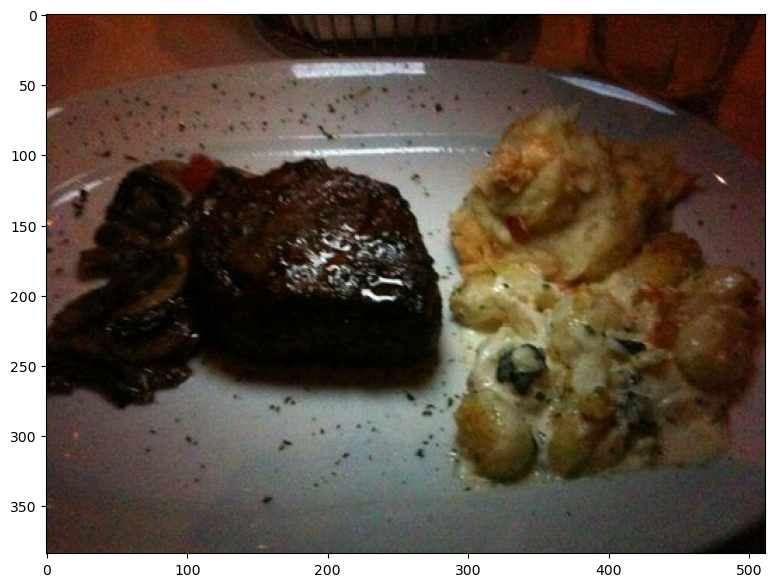

In [6]:
# getting paths of all images
image_path_list = list(image_path.glob("*/*/*.jpg"))

# select randomly from the image path list
random_image_path = random.choice(image_path_list)
random_image_class = random_image_path.parent.stem

# open image
img = Image.open(random_image_path)

# convert image to array
img_as_array = np.asarray(img)

# print metadata
print(f"Image Class: {random_image_class}")
print(f"Image Shape: {img_as_array.shape}") # height, width, color_channels

plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)

# Transforming data for use with a model
Before we use the image data with PyTorch:
1. Turn your target data into tensors
2. Turn it into torch.utils.data.Dataset and subsequently a torch.utils.data.DataLoader

In [7]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

__transforming data with `torchvision.transforms`__ <br>
__torchvision.transforms: https://pytorch.org/vision/0.9/transforms.html__

In [8]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)), # resizes image to 64x64
    transforms.RandomHorizontalFlip(p=0.5), # flips the images randomly on the horizontal
    transforms.ToTensor() # turn the image into torch.Tensor
])

# seeing the effect on the img
data_transform(img)

tensor([[[0.3647, 0.3608, 0.3686,  ..., 0.1216, 0.1216, 0.1922],
         [0.3569, 0.3569, 0.3490,  ..., 0.1294, 0.1333, 0.2275],
         [0.3490, 0.3569, 0.3216,  ..., 0.1294, 0.1529, 0.2627],
         ...,
         [0.2196, 0.2314, 0.2431,  ..., 0.1176, 0.0784, 0.0431],
         [0.2196, 0.2431, 0.2510,  ..., 0.0510, 0.0392, 0.0353],
         [0.2314, 0.2549, 0.2627,  ..., 0.0275, 0.0275, 0.0353]],

        [[0.1137, 0.1137, 0.1137,  ..., 0.0431, 0.0392, 0.0549],
         [0.1098, 0.1137, 0.1176,  ..., 0.0431, 0.0431, 0.0667],
         [0.1216, 0.1176, 0.1294,  ..., 0.0392, 0.0510, 0.0745],
         ...,
         [0.1490, 0.1529, 0.1569,  ..., 0.1098, 0.0471, 0.0196],
         [0.1412, 0.1490, 0.1529,  ..., 0.0353, 0.0157, 0.0196],
         [0.1569, 0.1529, 0.1529,  ..., 0.0196, 0.0196, 0.0196]],

        [[0.0510, 0.0471, 0.0471,  ..., 0.0196, 0.0275, 0.0235],
         [0.0510, 0.0549, 0.0549,  ..., 0.0196, 0.0235, 0.0314],
         [0.0627, 0.0667, 0.0667,  ..., 0.0196, 0.0235, 0.

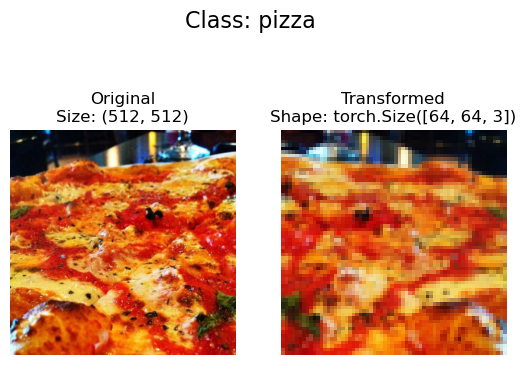

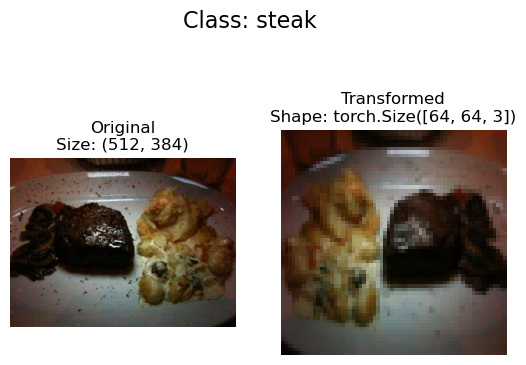

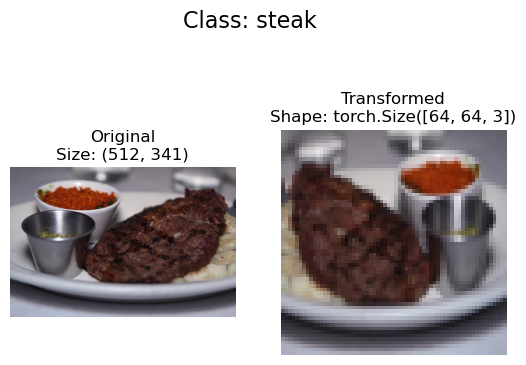

In [9]:
def plot_transformed_image(image_paths, transform, n=3, seed=None):
    """
    Selects random images from a path of images and loads/transforms
    them then plots the original vs the transformed version.
    """
    if seed:
        random.seed(seed)
        
    random_img_paths = random.sample(image_paths, k=n)
    for image_path in random_img_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            # plot original image
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)
            
            # plot transformed image
            transformed_image = transform(f).permute(1, 2, 0) # note we will need to change shape for matplotlib
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis(False)
            
            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)
            
            
plot_transformed_image(image_paths=image_path_list, transform=data_transform, n=3, seed=42)

# Loading custom data with pre-built functions and custom functions

__Option 1: Using ImageFolder__ <br>
__ImageFolder: https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html__

In [10]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, 
                                  transform=data_transform, # transform for the data
                                  target_transform=None) # transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [12]:
# get class names as list
class_names = train_data.classes

# get class names as dict
class_dict = train_data.class_to_idx

class_names, class_dict

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [13]:
# index on train_data dataset to get he single image and label
img, label = train_data[0][0], train_data[0][1]

print(f"Image Tensor:\n {img}")
print(f"Image Shape: {img.shape}")
print(f"Image Datatype: {img.dtype}")
print(f"Image Label: {label}")
print(f"Label Datatype:\n {type(label)}")

Image Tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0706, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0196, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

Original Shape: torch.Size([3, 64, 64]) -> color_channels, height, width
Permuted Shape: torch.Size([64, 64, 3]) -> height, width, color_channels


Text(0.5, 1.0, 'pizza')

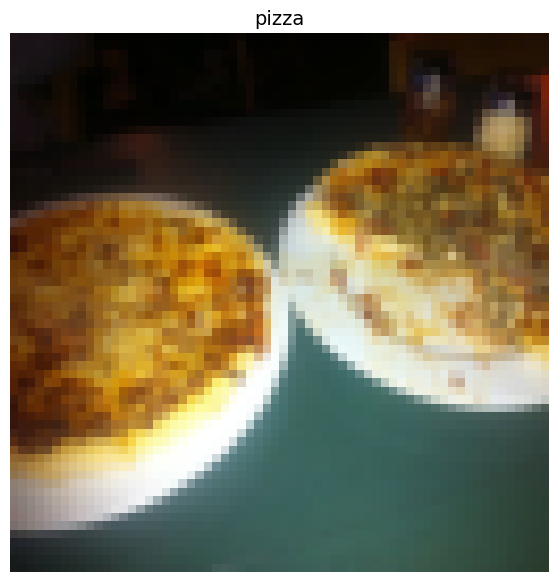

In [14]:
# rearrange dimensions for matplotlib
img_permute = img.permute(1, 2, 0)

# print out different shapes
print(f"Original Shape: {img.shape} -> color_channels, height, width")
print(f"Permuted Shape: {img_permute.shape} -> height, width, color_channels")

# plotting the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize=14)

__Creating DataLoaders__

In [15]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=5, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=5, shuffle=False)

len(train_dataloader), len(test_dataloader)

(45, 15)

In [16]:
# iterating through the data loader
img, label = next(iter(train_dataloader))

print(f"Image Shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label Shape: {label.shape}")

Image Shape: torch.Size([5, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label Shape: torch.Size([5])


__Option 2: Creating a Custom Dataset__ <br>
All custom datasets in Pytorch subclass this: __https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset__


In [17]:
import torch
import os, pathlib
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [20]:
# create a helper function to get class names

# get class name from the train_dir
class_names_found = sorted([entry.name for entry in list(os.scandir(train_dir))])
class_names_found

['pizza', 'steak', 'sushi']

In [22]:
def find_classes(dir: str) -> Tuple[List[str], Dict[str, int]]:
    class_names_list = sorted([entry.name for entry in list(os.scandir(train_dir))])
    class_names_dict = {class_names_list[i]: i for i in range(len(class_names_list))}
    
    return class_names_list, class_names_dict

find_classes(dir=train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

creating a `custom dataset` for replicating the `ImageFolder` <br>
To create our own custom dataset, we want to:
1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we would like to get data from) as well as the transform if we'd like to transform out data.
3. Create a several attributes:
> * paths - paths of out images
> * transform - the transform we'd like to use
> * classes - a list of the target classes
> * class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len()__` method to return the length of our dataset
6. Overwrite the `__getitem__()` method to return a given sample when passed as an index

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, targ_dir: str, transform=None):
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        self.tranform = transform
        self.class_names, self.class_to_idx = find_classes(targ_dir)